In [1]:
import os
import cv2
import numpy as np
import trimesh
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from utils.people_snapshot_dataset import People_Snapshot_Dataset
from utils.multi_garment_dataset import Multi_Garment_Dataset
from utils.iper_dataset import iPER_Dataset
from models.networks.smpl import SMPL
from models.networks.render import SMPLRenderer
from utils.util import load_obj, load_pickle_file, write_pickle_file

In [2]:
torch.cuda.set_device(1)

In [3]:
data_root = 'data/Multi-Garment_dataset'
vis_result_dir = 'outputs/vis_result'
pose_cam_path = 'assets/pose_cam.pkl'
isHres = True
image_size = 256
batch_size = 16
num_frame = 1

In [4]:
smpl = SMPL(pkl_path='assets/smpl_model.pkl', isHres=isHres).cuda()
if isHres:
    faces = smpl.faces_hres
else:
    faces = smpl.faces
smpl_render = SMPLRenderer(faces=faces).cuda()

In [5]:
smpl_render.set_bg_color((1, 1, 1))

In [6]:
smpl_render.set_ambient_light(int_dir=0.3, int_amb=0.7, direction=(1, 0.5, 0.5))

In [7]:
train_dataset = Multi_Garment_Dataset(data_root=data_root, pose_cam_path=pose_cam_path, num_frame=num_frame, isHres=isHres)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
for i, data in enumerate(train_loader):
    
    shape = data['shape'].cuda()
    pose = data['pose'].cuda()
    cam = data['cam'].cuda()
    v_personal = data['v_personal'].cuda()
    uv_image = data['uv_image'].cuda()
    f2vts = data['f2vts'].cuda()
    
    tex = smpl_render.extract_tex(uv_image, smpl_render.points_to_sampler(f2vts))
    
    print('shape: ', shape.size())
    print('pose: ', pose.size())
    print('cam: ', cam.size())
    print('v_personal: ', v_personal.size())
    print('uv_image: ', uv_image.size())
    print('f2vts: ', f2vts.size())
    print('tex: ', tex.size())
    
    if i >= 0:
        break

shape:  torch.Size([16, 10])
pose:  torch.Size([16, 72])
cam:  torch.Size([16, 3])
v_personal:  torch.Size([16, 27554, 3])
uv_image:  torch.Size([16, 3, 2048, 2048])
f2vts:  torch.Size([16, 55104, 3, 2])
tex:  torch.Size([16, 55104, 3, 3, 3, 3])


In [9]:
data_ref_root = 'data/iPER'
train_ID_list = []
for line in open(os.path.join(data_ref_root, 'train.txt')):
    train_ID_list.append(line.split()[0])
print(len(train_ID_list))

164


In [10]:
video_ID = train_ID_list[5]
print(video_ID)
imgs_path = os.path.join(data_ref_root, 'images', video_ID)
pose_shape_pkl_path = os.path.join(data_ref_root, 'smpls', video_ID, 'pose_shape.pkl')
train_ref_dataset = iPER_Dataset(imgs_path, pose_shape_pkl_path, image_size=image_size)
train_ref_loader = DataLoader(train_ref_dataset, batch_size=batch_size, shuffle=True)

001/6/2


In [11]:
for i, data in enumerate(train_ref_loader):
    img_ref = data['image'].cuda()
    shape_ref = data['shape'].cuda()
    pose_ref = data['pose'].cuda()
    cam_ref = data['cam'].cuda()
    print('img: ', img_ref.size())
    print('shape: ', shape_ref.size())
    print('pose: ', pose_ref.size())
    print('cam: ', cam_ref.size())
    if i >= 0:
        break

img:  torch.Size([16, 3, 256, 256])
shape:  torch.Size([16, 10])
pose:  torch.Size([16, 72])
cam:  torch.Size([16, 3])


In [20]:
verts_src = smpl(shape, pose, v_personal)
verts_src = smpl_render.project_to_image(verts_src, cam, flip=False, withz=True)

In [21]:
img_masked_src = smpl_render.render(verts_src, tex)
print(img_masked_src.size())

torch.Size([16, 3, 256, 256])


In [22]:
img_smpl_src = smpl_render.render(verts_src)
print(img_smpl_src.size())

torch.Size([16, 3, 256, 256])


In [23]:
verts_ref = smpl(shape, pose_ref, v_personal)
verts_ref = smpl_render.project_to_image(verts_ref, cam, flip=True, withz=True)

In [24]:
img_masked_ref = smpl_render.render(verts_ref, tex)
print(img_masked_ref.size())

torch.Size([16, 3, 256, 256])


In [25]:
verts = smpl(shape_ref, pose_ref)
verts = smpl_render.project_to_image(verts, cam_ref, flip=True, withz=True)

In [26]:
img_smpl_ref = smpl_render.render(verts)
print(img_smpl_ref.size())

torch.Size([16, 3, 256, 256])


In [27]:
vis_ID = 2

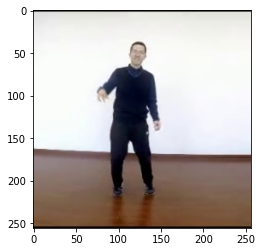

In [28]:
img_vis = (img_ref.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_vis)

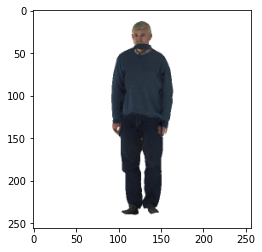

In [29]:
img_masked_src_vis = (img_masked_src.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_masked_src_vis)

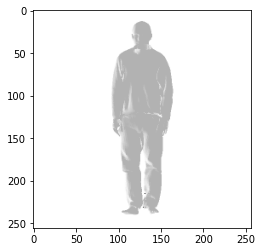

In [30]:
img_smpl_src_vis = (img_smpl_src.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_smpl_src_vis)

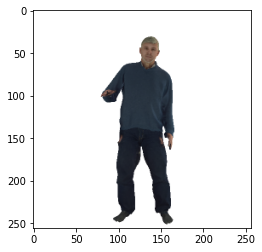

In [31]:
img_masked_ref_vis = (img_masked_ref.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_masked_ref_vis)

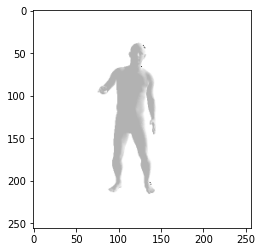

In [32]:
img_smpl_ref_vis = (img_smpl_ref.detach().cpu().numpy()[vis_ID] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_smpl_ref_vis)

In [33]:
for i in range(batch_size):
    save_image(img_ref[i].detach().cpu(), os.path.join(vis_result_dir, 'img_ref_{}.jpg'.format(i)))
    save_image(img_masked_src[i].detach().cpu(), os.path.join(vis_result_dir, 'img_masked_src_{}.jpg'.format(i)))
    save_image(img_masked_ref[i].detach().cpu(), os.path.join(vis_result_dir, 'img_masked_ref_{}.jpg'.format(i)))
    save_image(img_smpl_src[i].detach().cpu(), os.path.join(vis_result_dir, 'img_smpl_src_{}.jpg'.format(i)))
    save_image(img_smpl_ref[i].detach().cpu(), os.path.join(vis_result_dir, 'img_smpl_ref_{}.jpg'.format(i)))